<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA4_Phase1/blob/master/S11_One_Cycle_Policy_ResNet_Modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import datetime 
print("Current Date/Time: ", datetime.now())

Current Date/Time:  2020-04-11 17:17:03.170363


In [2]:
# Mounting the drive and copying the code from github to drive
from google.colab import drive 
drive.mount('/content/gdrive')
%cd gdrive/My Drive/project_folder
!git clone https://github.com/anilbhatt1/Deep_Learning_EVA4_Phase1
%cd Deep_Learning_EVA4_Phase1/S11_OneCyclePolicy_ResNet_Modified
! ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/project_folder
Cloning into 'Deep_Learning_EVA4_Phase1'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 1417 (delta 35), reused 0 (delta 0), pack-reused 1357
Receiving objects: 100% (1417/1417), 15.83 MiB | 14.94 MiB/s, done.
Resolving deltas: 100% (864/864), done.
Checking out files: 100% (111/111), done.
/content/gdrive/My Drive/project_folder/Deep_Learning_EVA4_Phase1/S11_OneCyclePolicy_ResNet_Modified
models	README.md


In [4]:
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import cv2
from models import Alb_data_transforms,Model,Dataloaders,Train_Losses,Test_losses
import pkgutil
import importlib
%matplotlib inline

# install "apex" model for mixed precision training if required.. this is needed for LRFinder
if pkgutil.find_loader("apex") is None:
   print("****apex module does not exist..hence installing*****")
   !pip install -U git+https://www.github.com/NVIDIA/apex --no-cache-dir

import albumentations
print(albumentations.__version__) # check version

# This is to install and use albumentations latest package v0.4.5
album_version_needed = "0.4.5"
if albumentations.__version__ != album_version_needed:
  !pip install albumentations==0.4.5   # 0.4.5 is the latest albumentation version

print('Pytorch version:', torch.__version__)  

0.4.5
Pytorch version: 1.4.0


#### Below section of code is to get the mean and stdev of train data which will be used for normalization while applying transforms. **No need to execute this everytime** we run the file

In [0]:
train = torchvision.datasets.CIFAR10('./data', train=True, download=True)

n = 0
s = np.zeros(3)
sq = np.zeros(3)
i = 0
batchsize = 128
for data, l in tqdm_notebook(train):
  x = np.array(data)/255                             # Image Normalization 
  s += x.sum(axis=(0,1))                             # Summing up x & y values across 3 channels - CIFAR 10 size is 32,32,3. Useful for mean 
  sq += np.sum(np.square(x), axis=(0,1))             # Summing up x^2 and y^2 values across 3 channels. Useful for std dev calculation
  n += x.shape[0]*x.shape[1]                         # Summing up no: of pixels.Each channel has 32x32. Final pixels per channel = # images * 32 *32
  i += 1

batches = int(i/batchsize)
mu = s/n                               # mean = sum of pixel values/ no: of pixel values. Will return 3 element array as CIFAR10 has 3 channels
std = np.sqrt((sq/n - np.square(mu)))  # std dev = sqrt[sigma{x(i) - mean}^2/N]. Will return 3 element array as CIFAR10 has 3 channels
print('No: Of Train Images:', i, '\n'
      'No: Of Batches:', batches, '\n'
      'Channels Mean:',mu, '\n'
      'Channels Stdev:',std, '\n'
      'Channels squared sum mean:', sq/n, '\n'
      'Total Pixles (N):', n)

Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



No: Of Train Images: 50000 
No: Of Batches: 390 
Channels Mean: [0.49139968 0.48215841 0.44653091] 
Channels Stdev: [0.24703223 0.24348513 0.26158784] 
Channels squared sum mean: [0.30249857 0.29176174 0.26781806] 
Total Pixles (N): 51200000


#### Code section to **load** the train and test data and **applying transforms**

In [5]:
import albumentations as A

class_list = [0,1,2,3,4,5,6,7,8,9]
class_names_dict = {0:'plane', 1:'automob', 2:'bird', 3:'cat',4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
class_names = ['plane', 'automobile', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

data_loader = Dataloaders.DataLoader(shuffle=True,batch_size=128,seed=1)

channels_mean  = (0.49139968, 0.48215841, 0.44653091)
channels_stdev = (0.24703223, 0.24348513, 0.26158784)
fillmeans = (np.array(channels_mean)*255).astype(np.uint8) # This is to fill additional space coming up while rotating image
              
test_transforms   = Alb_data_transforms.Albumentations_transform([A.Normalize(mean=channels_mean, std=channels_stdev)])
train_transforms  = Alb_data_transforms.Albumentations_transform([A.Rotate((-15.0, 15.0)),
                                                                  A.HorizontalFlip(),
                                                                  A.IAAAdditiveGaussianNoise(),
                                                                  A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                                                  A.Normalize(mean=channels_mean, std=channels_stdev),
                                                                  A.Cutout(num_holes=1,max_h_size=8,max_w_size=8), 
                                                                  # Using default fillvalue=0 for cutout because after normalizing mean is 0
                                                                  # Size used for cutout as 8 i.e. 25% of 32x32 CIFAR 10 data                                                                 
                                                                 ])

train_data = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data  = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

trainloader = data_loader.load(train_data)
testloader  = data_loader.load(test_data)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#### Below function is to **unnormalize and bring back** the images to original pixel values. Function will be called while displaying images

In [0]:
channels_mean  = (0.49139968, 0.48215841, 0.44653091)
channels_stdev = (0.24703223, 0.24348513, 0.26158784)

# Function to unnormalize and bring back to original pixel values. Transpose is to reshape the image on x & y axes and make it ready for display

def unnormalize(img):
  #print('Unnorm')
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channels_stdev[i])+channels_mean[i]
  
  return np.transpose(img, (1,2,0))

#### Below section of code is to **display train images** from training set to get a high level idea on how our image dataset looks like with transforms



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 32, 32])
torch.Size([128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

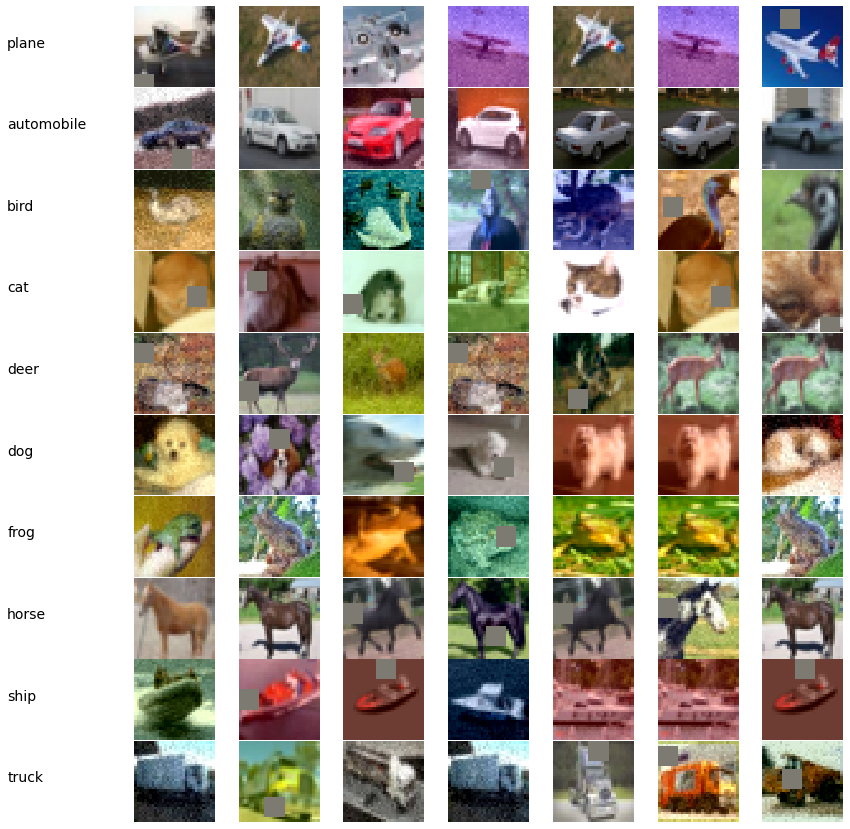

In [7]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 7 images from each category. 
class_names = ['plane', 'automobile', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

row, col = 10, 8
num_images = 7
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for class_num in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==class_num)[0], num_images)  ## Selecting 7 random images for each class
    ax = plt.subplot(row, col,class_num*col+1)                             ## Laying out space for display of a particular class
    ax.text(-0.1, 0.5, class_names[class_num], fontsize=14)                ## Displaying class names
    plt.axis('off')
    for j in range(1, num_images+1):                                       ## Displaying images one-by-one for a particular class
      plt.subplot(row, col, class_num*col+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [8]:
!pip install torchsummary
from torchsummary import summary
model = Model.ResNet_S11()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3          [-1, 128, 32, 32]          73,728
         MaxPool2d-4          [-1, 128, 16, 16]               0
       BatchNorm2d-5          [-1, 128, 16, 16]             256
            Conv2d-6          [-1, 128, 16, 16]         147,456
       BatchNorm2d-7          [-1, 128, 16, 16]             256
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
   BasicBlock_S11-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         294,912
        MaxPool2d-12            [-1, 256, 8, 8]               0
      BatchNorm2d-13            [-1, 256, 8, 8]             512
           Conv2d-14            [-1, 51

In [0]:
train_loss = Train_Losses.Train_loss()
test_loss  = Test_losses.Test_loss()

#### Function to calculate **class-wise Test Accuracy**

In [0]:
class_list = [0,1,2,3,4,5,6,7,8,9]

def calc_classwiseacc(total_cnt,correct_cnt):
    class_test_acc = []
    epsilon    = 1e-10                     # To avoid division by zero incase not a single image showed up for a particular class
    for i in range(len(class_list)):
        correct_class   =  total_class = 0
        correct_class   =  correct_cnt.get(class_list[i])
        total_class     =  total_cnt.get(class_list[i])
        total_class     += epsilon
        class_accuracy  =  round((correct_class/total_class *100), 2)
        class_test_acc.append(class_accuracy)
        print ('Test accuracy for class - ', class_list[i], ' - ', class_names_dict.get(class_list[i]), ' : ', class_accuracy, \
               'correct:',correct_class, 'Total:',int(total_class) )
    
    print('Total Test Images:',sum(total_cnt.values()),'Correct Images:',sum(correct_cnt.values()) )

    return class_test_acc   

#### Print the **Layer/module names*** of model

In [11]:
for name, module in model.named_modules():
    print('name:',name)

name: 
name: conv1
name: bn1
name: conv2
name: pool1
name: bn2
name: layer1
name: layer1.0
name: layer1.0.conv1
name: layer1.0.bn1
name: layer1.0.conv2
name: layer1.0.bn2
name: layer1.0.shortcut
name: conv3
name: pool2
name: bn3
name: conv4
name: pool3
name: bn4
name: layer2
name: layer2.0
name: layer2.0.conv1
name: layer2.0.bn1
name: layer2.0.conv2
name: layer2.0.bn2
name: layer2.0.shortcut
name: pool4
name: fc


# Train and Test the model using ReduceLROnPlateau

**ReduceLROnPlateau-**Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This scheduler reads a metrics quantity and if no improvement is seen for a ‘patience’ number of epochs, the learning rate is reduced by 'factor' supplied. 

mode = 'min' means lr will be reduced when the quantity monitored has stopped decreasing; in 'max' mode it will be reduced when the quantity monitored has stopped increasing.

'min_lr' -> A lower bound on the LR upto which it can be reduced

In [12]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR

EPOCH         = 5
L2_factor     = 0.0001
L1_factor     = 0.0005
least_loss_lr = 0.0012

train_loss_all = []
train_acc_all  = []
test_loss_all  = []
test_acc_all   = []
classwise_acc  = []
class_acc_all  = []

OPTIMIZER = optim.SGD(model.parameters(), lr=least_loss_lr, momentum=0.9, weight_decay=L2_factor)
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode = 'min', factor = 0.1, min_lr=1e-7, patience = 4, verbose=True)
criterion = nn.CrossEntropyLoss()

for epoch in range(EPOCH):

    print("\nEPOCH:", epoch)
    train_losses, train_acc = train_loss.train_loss_calc(model,model.device,train_loader=trainloader,optimizer=OPTIMIZER,
                                                         epoch=EPOCH,factor=L1_factor,criterion=criterion,scheduler=SCHEDULER,print_idx=0,maxlr=0.2)
    test_losses, test_acc, wrong_predict, predicted_class, actual_class, label_total, label_correct = \
                              test_loss.test_loss_calc(model,model.device,test_loader=testloader, optimizer=OPTIMIZER, total_epoch=EPOCH, 
                                                       current_epoch = epoch,criterion=criterion,scheduler=SCHEDULER)                  
        
    train_loss_all.extend(train_losses)
    train_acc_all.extend(train_acc)
    test_loss_all.extend(test_losses)
    test_acc_all.extend(test_acc)

    if len(test_loss_all) > 1:
       loss_decrease = 0                  
       loss_decrease = test_loss_all[-2] - test_loss_all[-1]                             
       if loss_decrease > 0:
          print('Test Loss -> Decreasing, Prev Loss: {:.6f}, Latest Loss: {:.6f}, Delta: {:.6f}' .format(test_loss_all[-2], test_loss_all[-1], loss_decrease))     
       else: 
          print('Test Loss -> Increasing, Prev Loss: {:.6f}, Latest Loss: {:.6f}, Delta: {:.6f}' .format(test_loss_all[-2], test_loss_all[-1], loss_decrease))  

    if epoch == (EPOCH -1):
      classwise_acc = calc_classwiseacc(label_total,label_correct)
      class_acc_all.append(classwise_acc)              

  0%|          | 0/391 [00:00<?, ?it/s]


EPOCH: 0


Train Loss = 1.173551321029663 Batch Id = 390 Train Acc = 45.63 LR =0.001200: 100%|██████████| 391/391 [01:41<00:00,  3.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0099, Test Accuracy: 57.66, LR : 0.001200

EPOCH: 1


Train Loss = 0.9543529152870178 Batch Id = 390 Train Acc = 61.82 LR =0.001200: 100%|██████████| 391/391 [01:41<00:00,  3.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Test Accuracy: 68.23, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.009938, Latest Loss: 0.007002, Delta: 0.002936

EPOCH: 2


Train Loss = 0.8361602425575256 Batch Id = 390 Train Acc = 69.33 LR =0.001200: 100%|██████████| 391/391 [01:41<00:00,  3.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Test Accuracy: 74.89, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.007002, Latest Loss: 0.005742, Delta: 0.001260

EPOCH: 3


Train Loss = 0.7854529023170471 Batch Id = 390 Train Acc = 73.88 LR =0.001200: 100%|██████████| 391/391 [01:41<00:00,  3.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Test Accuracy: 76.19, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.005742, Latest Loss: 0.005441, Delta: 0.000301

EPOCH: 4


Train Loss = 0.782903254032135 Batch Id = 390 Train Acc = 76.94 LR =0.001200: 100%|██████████| 391/391 [01:41<00:00,  3.85it/s]



Test set: Average loss: 0.0050, Test Accuracy: 78.39, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.005441, Latest Loss: 0.005003, Delta: 0.000438
Test accuracy for class -  0  -  plane  :  88.0 correct: 880 Total: 1000
Test accuracy for class -  1  -  automob  :  89.9 correct: 899 Total: 1000
Test accuracy for class -  2  -  bird  :  77.3 correct: 773 Total: 1000
Test accuracy for class -  3  -  cat  :  51.4 correct: 514 Total: 1000
Test accuracy for class -  4  -  deer  :  83.9 correct: 839 Total: 1000
Test accuracy for class -  5  -  dog  :  57.6 correct: 576 Total: 1000
Test accuracy for class -  6  -  frog  :  78.4 correct: 784 Total: 1000
Test accuracy for class -  7  -  horse  :  83.3 correct: 833 Total: 1000
Test accuracy for class -  8  -  ship  :  85.6 correct: 856 Total: 1000
Test accuracy for class -  9  -  truck  :  88.5 correct: 885 Total: 1000
Total Test Images: 10000 Correct Images: 7839


#### Below section of code is to plot **misclassified images** received from last epoch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


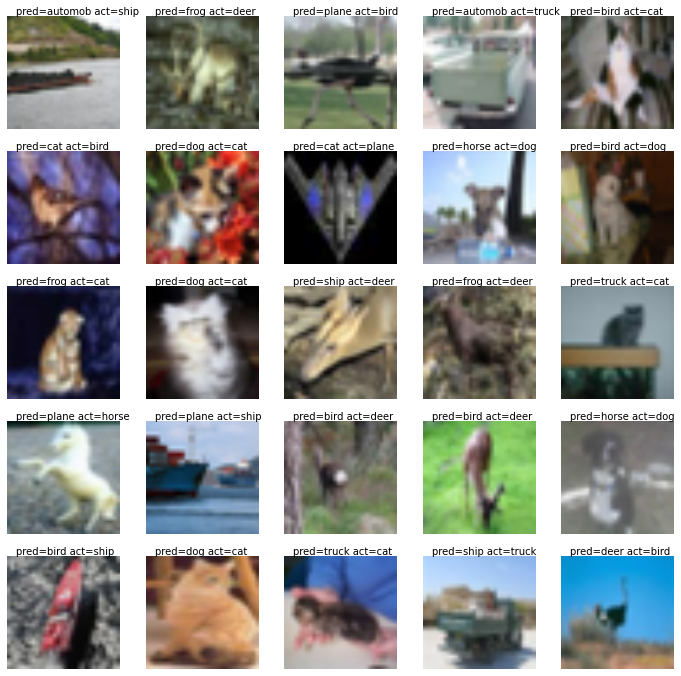

In [0]:
# Plotting misclassified images received from last epoch. Will throw error message if misclassified images <25. 
# In case of such an event adjust the subplots to suit the number of images to be plotted

figure=plt.figure(figsize=(12,12))
if len(predicted_class) > 25: 
    for i in range(25):
      plt.subplot(5,5,i+1)
      plt.axis(False)
      #plt.imshow(unnormalize(wrong_predict[i].cpu()), interpolation='none')
      plt.imshow(unnormalize(wrong_predict[i].cpu()),interpolation='bilinear')
      prediction = class_names_dict.get(predicted_class[i])
      actual     = class_names_dict.get(actual_class[i])
      s="pred="+str(prediction)+" act="+str(actual)
      #s="predicted="+str(predicted_class[i])+" actual="+str(actual_class[i])
      plt.text(2,-1,s)
else:
  print('Less than 25 images:', len(predicted_class))

#### Below section of code is to plot **validation accuracy, test loss, training accuracy and train loss** for the all the epochs trained

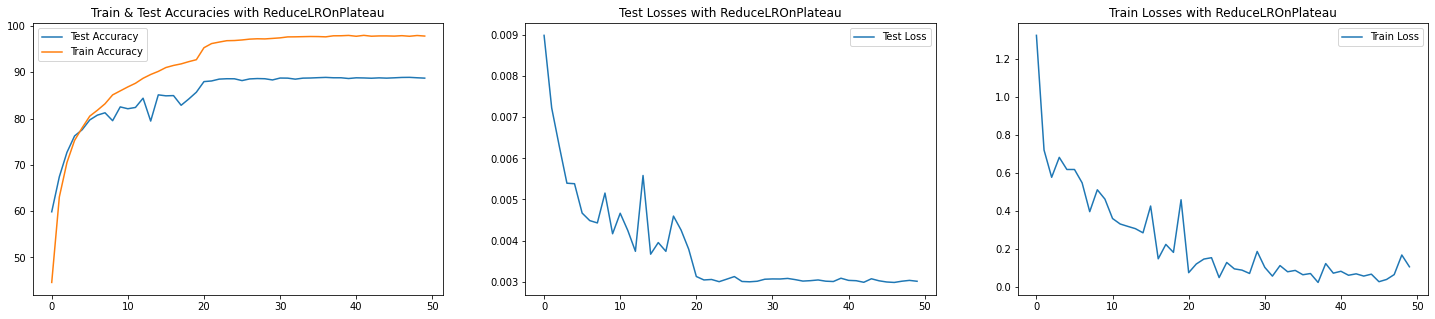

In [0]:
figure = plt.figure(figsize=(25,5))
labels = ['With L1=0.0001 & L2=0.0005']

plt.subplot(1,3,1)
plt.title("Train & Test Accuracies with ReduceLROnPlateau")
plt.plot(test_acc_all,label='Test Accuracy')
plt.plot(train_acc_all,label='Train Accuracy')
plt.legend(loc="best")

plt.subplot(1,3,2)
plt.title("Test Losses with ReduceLROnPlateau")
plt.plot(test_loss_all,label='Test Loss')
plt.legend(loc="best")

plt.subplot(1,3,3)
plt.title("Train Losses with ReduceLROnPlateau")
plt.plot(train_loss_all,label='Train Loss')
plt.legend(loc="best")   

##Gradcam



In [0]:
img_all = img_1 = img_2 = img_3 = []
target_all = target_1 = target_2 = target_3 = []
test1_transforms   = Alb_data_transforms.Albumentations_transform([])
target_layers = ["layer1","layer2","layer3","layer4"]
#Grad_CAM1(model,target_layers)

for i in range(len(wrong_predict)):
     img = wrong_predict[i].cpu().numpy()
     img = np.transpose(img, (1,2,0))
     img = test1_transforms(img)
     img_all.append(img)
     target_all.append(actual_class[i])

img_1 = img_all[0:10]
img_2 = img_all[10:20]
img_3 = img_all[20:25]
target_1 = target_all[0:10]
target_2 = target_all[10:20]
target_3 = target_all[20:25]

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


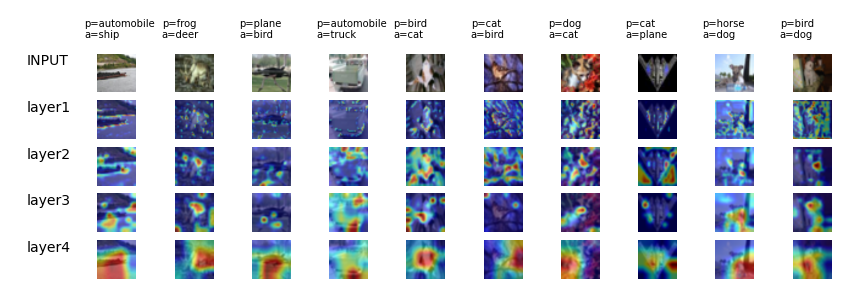

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


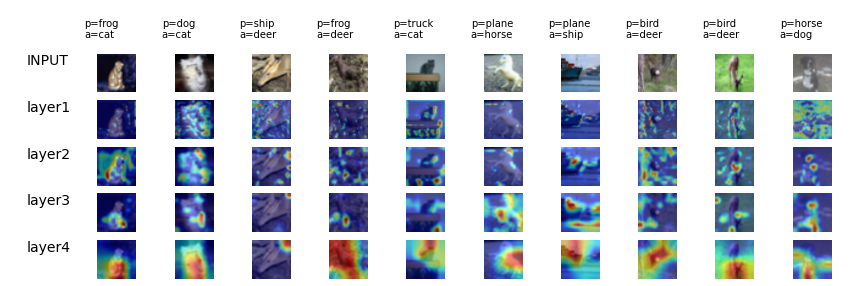

torch.Size([5, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


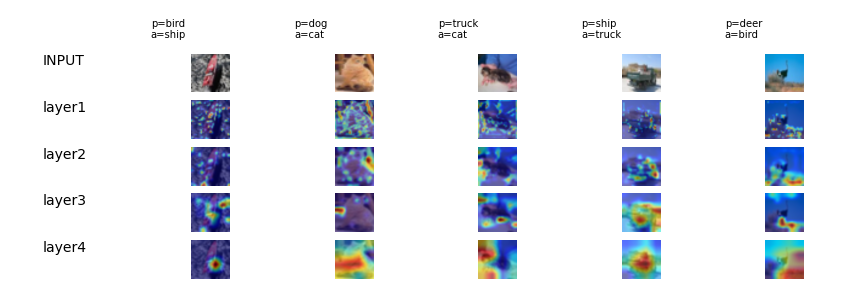

In [0]:
images = []
target_classes = [] 
grad_cam_list = [1,2,3]
for i in range(len(grad_cam_list)):
    if i == 0:
      images = img_1
      target_classes = target_1
    elif i == 1:
      images = img_2
      target_classes = target_2
    elif i == 2:
      images = img_3
      target_classes = target_3    
    gradcam_output, probs, predicted_classes = Gradcam.GRADCAM(images, target_classes, model, target_layers)
    Gradcam.PLOT(gradcam_output, images, target_classes, target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)
    images = []
    target_classes = []     

In [0]:
''' 
 ## Modified ResNet 18 model for training CIFAR10. "_S11" simply stands for session 11 as this belongs to 11th session of EVA4 program

class BasicBlock_S11(nn.Module):
    expansion  = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock_S11, self).__init__()
        #print('Inside BasicBlock Class Making conv1 :in_planes, planes, stride : ', in_planes, planes, stride)        
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        #print('self.conv1:',self.conv1)
        #print('Inside BasicBlock Class Making BN1 :planes : ', planes)                
        self.bn1 = nn.BatchNorm2d(planes)
        #print('self.bn1:',self.bn1)
        #print('Inside BasicBlock Class Making conv2 :planes : ', planes)           
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        #print('self.conv2:',self.conv2)
        #print('Inside BasicBlock Class Making BN2 :planes : ', planes)          
        self.bn2 = nn.BatchNorm2d(planes)
        #print('self.bn2:',self.bn2)          

        #print('Inside BasicBlock Class Making Shortcut')
        self.shortcut = nn.Sequential()
        print('Inside BasicBlock Class self.shortcut : ', self.shortcut)            
        if stride != 1 or in_planes != self.expansion*planes:
            print('Basic Block, Inside IF block to create SHORTCUT -stride:', stride, 'in_planes:',in_planes, 'planes:',planes, 'self.expansion:',self.expansion)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
            #print('Basic Block, After self.shortcut creation:',self.shortcut)            

    def forward(self, x):
        #print('Basic Block Input step: x', x.shape, '/n')      
        out = F.relu(self.bn1(self.conv1(x)))
        #print('Basic Block after F.relu(self.bn1(self.conv1(x))):', out.shape, '/n')           
        out = F.relu(self.bn2(self.conv2(out)))
        #print('Basic Block after self.bn2(self.conv2(out)):', out.shape, '/n')               
        out += F.relu(self.shortcut(x))
        #print('Basic Block after adding short cut i.e out += F.relu(self.shortcut(x)):',out.shape,'/n' )            
        return out
    
class ResNet_mod_S11(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet_mod_S11, self).__init__()
        self.in_planes  = [128,512]
        self.layer_call = 0

        print('Inside ResNet Class Making conv1')
        self.conv1  = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        print('Resnet self.conv1:',self.conv1)
        print('Inside ResNet Class Making Batchnorm1')
        self.bn1    = nn.BatchNorm2d(64)
        print('Resnet self.bn1:',self.bn1)
        print('Inside ResNet Class Making conv2')
        self.conv2  = nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1, bias=False)
        print('Resnet self.conv2:',self.conv2)
        print('Inside ResNet Class Making Pool-1')
        self.pool1  = nn.MaxPool2d(2, 2)
        print('pool-1:',self.pool1)
        print('Inside ResNet Class Making Batchnorm2')
        self.bn2    = nn.BatchNorm2d(128)
        print('Resnet self.bn2:',self.bn2)
        print('Inside ResNet Class Making Layer 1, self.layer_call:',self.layer_call)        
        self.layer1 = self._make_layer(block, 128, num_blocks[0], stride=1)
        print('After layer 1, self.layer_call:',self.layer_call)
        print('Resnet self.layer1:',self.layer1)
        print('Inside ResNet Class Making conv3')
        self.conv3  = nn.Conv2d(128,256, kernel_size=3, stride=1, padding=1, bias=False)
        print('Resnet self.conv3:',self.conv3)
        print('Inside ResNet Class Making Pool-2')
        self.pool2  = nn.MaxPool2d(2, 2)
        print('pool-2:',self.pool2)
        print('Inside ResNet Class Making Batchnorm3')
        self.bn3    = nn.BatchNorm2d(256)
        print('Resnet self.bn3:',self.bn3)
        print('Inside ResNet Class Making conv4')
        self.conv4  = nn.Conv2d(256,512, kernel_size=3, stride=1, padding=1, bias=False)
        print('Resnet self.conv4:',self.conv4)
        print('Inside ResNet Class Making Pool-3')
        self.pool3  = nn.MaxPool2d(2, 2)
        print('pool-3:',self.pool3)
        print('Inside ResNet Class Making Batchnorm4')
        self.bn4    = nn.BatchNorm2d(512)
        print('Resnet self.bn4:',self.bn4)
        print('Inside ResNet Class Making Layer 2, self.layer_call:',self.layer_call)
        self.layer2 = self._make_layer(block, 512, num_blocks[1], stride=1)
        print('After layer 2, self.layer_call:',self.layer_call)
        print('Resnet self.layer2:',self.layer2)
        print('Inside ResNet Class Making Pool-4')
        self.pool4  = nn.MaxPool2d(4, 4)
        print('pool-4:',self.pool4)
        print('Inside ResNet Class Making FC Layer')
        self.fc     = nn.Conv2d(512*block.expansion, num_classes, kernel_size=1, stride = 1, padding=0, bias=False)
        print('Resnet self.fc:',self.fc)
        
    def _make_layer(self, block, planes, num_blocks, stride):
        print('_make_Layer starts -> Block:',block,' Planes:',planes,'num_blocks:',num_blocks,'stride:',stride)
        strides = [stride] + [1]*(num_blocks-1)
        print('Inside Make Layers : _make_layer_ calculation, strides : ', strides)
        layers = []
        i = 0
        for stride in strides:
            #print('Resnet For Loop iteration:',  i)
            #print('Inside Make Layers before calling BLOCK : layers:',layers)
            layers.append(block(self.in_planes[self.layer_call], planes, stride))
            #print('Inside Make Layers : stride:',stride,'self.in_planes:',self.in_planes,'planes:',planes,'block.expansion:',block.expansion)
            #print('Inside Make Layers After calling BLOCK layers:',layers)
            self.in_planes[self.layer_call] = planes * block.expansion
            #print('Inside Make Layers self.in_planes :',self.in_planes)
            #print('Inside Make Layers nn.Sequential(*layers):',nn.Sequential(*layers))
            i += 1
        self.layer_call += 1    
        return nn.Sequential(*layers)

    def forward(self, x):
        print('I/P Shape:',x.shape)
        out = F.relu(self.bn1(self.conv1(x)))
        print('After F.relu(self.bn1(self.conv1(x))):', out.shape)
        out = F.relu(self.bn2(self.pool1(self.conv2(out))))
        print('After F.relu(self.bn2(self.pool1(self.conv2(out)))):',out.shape)
        out = self.layer1(out)
        print('After self.layer1(out):',out.shape)
        out = F.relu(self.bn3(self.pool2(self.conv3(out))))
        print('After F.relu(self.bn3(self.pool2(self.conv3(out)))):',out.shape)
        out = F.relu(self.bn4(self.pool3(self.conv4(out))))
        print('After F.relu(self.bn4(self.pool3(self.conv4(out)))):',out.shape)
        out = self.layer2(out)
        print('After self.layer2(out):',out.shape)
        out = self.pool4(out)
        print('After self.pool4(out):',out.shape)
        out = self.fc(out)
        print('After self.fc(out):',out.shape)
        out = out.view(out.size(0), -1)
        print('out.view(out.size(0), -1):',out.shape)
        return F.log_softmax(out, dim=-1)
            
def ResNet_S11():
    return ResNet_mod_S11(BasicBlock_S11, [1,1])
'''    

In [0]:
'''
!pip install torchsummary
from torchsummary import summary
model = ResNet_S11()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
summary(model, input_size=(3, 32, 32))
'''